In [1]:
cd ../../

/home/bluesun/PycharmProjects/tmp/BERTAP_v2


/home/bluesun/anaconda3/envs/rl/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
pwd

'/home/bluesun/PycharmProjects/tmp/BERTAP_v2'

In [3]:
import jax
import gym, d4rl
from src.datasets.d4rl_utils import qlearning_dataset
from src.utils.ant_viz import GoalReachingMaze

env_name = 'maze2d-large-v1'
env = gym.make(env_name)

r_data = env.get_dataset()

/home/bluesun/anaconda3/envs/rl/lib/python3.11/site-packages/Cython/Distutils/old_build_ext.py:15: DeprecationWarning: dep_util is Deprecated. Use functions from setuptools instead.
  from distutils.dep_util import newer, newer_group
<frozen importlib._bootstrap>:283: DeprecationWarning: the load_module() method is deprecated and slated for removal in Python 3.12; use exec_module() instead
No module named 'flow'
/home/bluesun/anaconda3/envs/rl/lib/python3.11/site-packages/glfw/__init__.py:914: GLFWError: (65544) b'X11: The DISPLAY environment variable is missing'
  warnings.warn(message, GLFWError)
No module named 'carla'
pybullet build time: Nov 28 2023 23:48:36
/home/bluesun/anaconda3/envs/rl/lib/python3.11/site-packages/pybullet_envs/env_bases.py:8: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import parse_version
/home/bluesun/anaconda3/envs/rl/lib/python3.11/site-packages/pkg_resources/_

In [4]:
import numpy as np
from pprint import pp

np.set_printoptions(linewidth=200)

pp(jax.tree.map(np.shape, r_data))

{'actions': (4000000, 2),
 'infos/goal': (4000000, 2),
 'infos/qpos': (4000000, 2),
 'infos/qvel': (4000000, 2),
 'observations': (4000000, 4),
 'rewards': (4000000,),
 'terminals': (4000000,),
 'timeouts': (4000000,)}


In [5]:
timeouts = r_data['timeouts']
timeout_ids = np.where(timeouts)[0]
timeout_ids[:10]

array([ 249,  454,  736, 1071, 1657, 1760, 1986, 2331, 2727, 2830])

## 1. Visualization

Unlike the `antmaze`, maze board of `maze2d` environment is transposed.
So, We should transpose either maze board or agent's position to visualize it correctly.

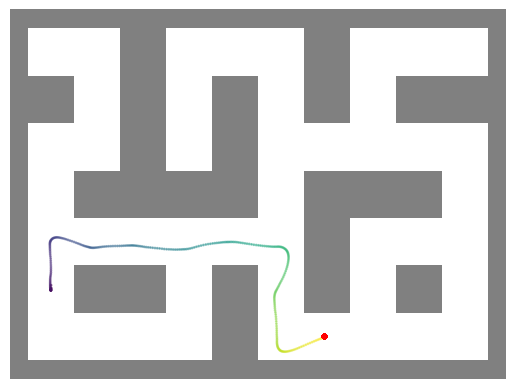

In [6]:
import matplotlib.pyplot as plt

render_env = GoalReachingMaze(env_name)
render_env.draw()

i = 199
c = np.linspace(0, 1, timeout_ids[i + 1] - timeout_ids[i])
st = slice(timeout_ids[i] + 1, timeout_ids[i + 1] + 1)
plt.scatter(r_data['observations'][st, 1], r_data['observations'][st, 0], c=c, cmap='viridis', alpha=0.5, s=1)
plt.scatter(r_data['infos/goal'][st, 1], r_data['infos/goal'][st, 0], c='r', s=10)

Each trajectory is connected with each other, but goal is instantly changed after reaching the goal.

/tmp/ipykernel_268326/637249744.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(r_data['observations'][st, 1], r_data['observations'][st, 0], c=f'C{i}', cmap='viridis', alpha=0.5, s=1)


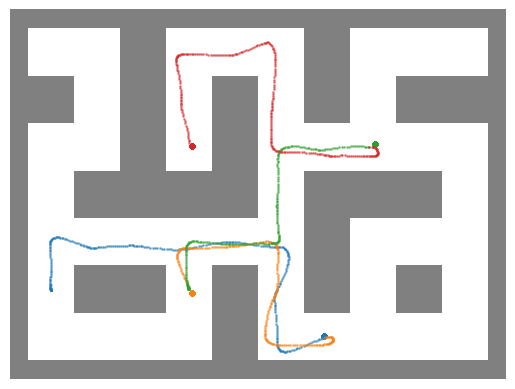

In [7]:
render_env.draw()
for i in range(4):
    k = i + 199
    st = slice(timeout_ids[k] + 1, timeout_ids[k + 1] + 1)
    plt.scatter(r_data['observations'][st, 1], r_data['observations'][st, 0], c=f'C{i}', cmap='viridis', alpha=0.5, s=1)
    plt.scatter(r_data['infos/goal'][st, 1], r_data['infos/goal'][st, 0], c=f'C{i}', s=10)

## 2. Dataset

In [8]:
print(timeout_ids[:10])

[ 249  454  736 1071 1657 1760 1986 2331 2727 2830]


### 2.1 Terminal Condition

**Summary**
- All episodes are sequentially connected.
- The terminal state of the episode and the initial state of the next episode are the same.

In [9]:
st = slice(timeout_ids[0] - 5, timeout_ids[0] + 5)
np.c_[r_data["observations"][st, :2], r_data["infos/goal"][st], r_data["timeouts"][st]]

array([[3.0102136, 8.749925 , 3.0295458, 9.002356 , 0.       ],
       [3.0055444, 8.78538  , 3.0295458, 9.002356 , 0.       ],
       [3.0018442, 8.81837  , 3.0295458, 9.002356 , 0.       ],
       [2.9977927, 8.849228 , 3.0295458, 9.002356 , 0.       ],
       [2.995175 , 8.877631 , 3.0295458, 9.002356 , 0.       ],
       [2.9942422, 8.9035845, 3.0295458, 9.002356 , 1.       ],
       [2.9942422, 8.9035845, 7.01233  , 7.9882717, 0.       ],
       [2.9914258, 8.952931 , 7.01233  , 7.9882717, 0.       ],
       [2.9901116, 8.981087 , 7.01233  , 7.9882717, 0.       ],
       [2.9890475, 9.011558 , 7.01233  , 7.9882717, 0.       ]], dtype=float32)

Note that observation is not changed just after reaching the goal.

In [10]:
st = slice(timeout_ids[1], timeout_ids[1] + 2)
np.c_[r_data["observations"][st], r_data["infos/goal"][st]]

array([[6.934996  , 7.989043  , 3.498105  , 0.25165215, 7.01233   , 7.9882717 ],
       [6.934996  , 7.989043  , 3.498105  , 0.25165215, 0.99318725, 9.051789  ]], dtype=float32)

In [11]:
goal_changed = np.where(np.linalg.norm(r_data['infos/goal'][1:] - r_data['infos/goal'][:-1], axis=1) > 1e-6)[0]
obs_unchanged = np.where(np.linalg.norm(r_data['observations'][1:] - r_data['observations'][:-1], axis=1) < 1e-6)[0]

print(np.allclose(goal_changed, timeout_ids))
print(np.allclose(obs_unchanged, timeout_ids))

True
True


### 2.2 Reward Signal

**Summary**
- Reward was labeled incorrectly.
- So, we have to relabel the reward signal.

In [12]:
print(r_data["rewards"])
np.where(r_data["rewards"] > 0)[0][50:60]

[0. 0. 0. ... 0. 0. 0.]


array([5909, 5910, 5911, 5912, 5913, 5914, 5915, 5916, 5917, 5918])

In [13]:
st = slice(timeout_ids[0] - 5, timeout_ids[0] + 5)
np.c_[r_data["observations"][st, :2], r_data["rewards"][st], r_data["timeouts"][st]]

array([[3.0102136, 8.749925 , 0.       , 0.       ],
       [3.0055444, 8.78538  , 0.       , 0.       ],
       [3.0018442, 8.81837  , 0.       , 0.       ],
       [2.9977927, 8.849228 , 0.       , 0.       ],
       [2.995175 , 8.877631 , 0.       , 0.       ],
       [2.9942422, 8.9035845, 0.       , 1.       ],
       [2.9942422, 8.9035845, 0.       , 0.       ],
       [2.9914258, 8.952931 , 0.       , 0.       ],
       [2.9901116, 8.981087 , 0.       , 0.       ],
       [2.9890475, 9.011558 , 0.       , 0.       ]], dtype=float32)

We can see reward is delayed, it seems error. Then, we should relabel the reward signal.
From [D4RL docs](https://github.com/Farama-Foundation/D4RL/wiki/Tasks#maze2d), reward = 1.0 when the agent is within a 0.5 radius of the target ball.

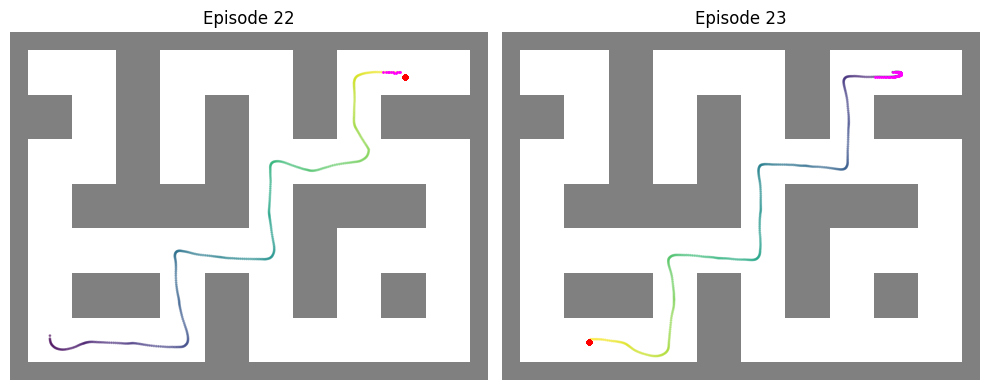

In [14]:
plt.figure(figsize=(10, 4))
for i in range(22, 24):
    plt.subplot(1, 2, i - 22 + 1)

    st = slice(timeout_ids[i] + 1, timeout_ids[i + 1] + 1)
    c = np.linspace(0, 1, timeout_ids[i + 1] - timeout_ids[i])
    rc = r_data['rewards'][st] > 0

    render_env.draw()
    plt.scatter(r_data['observations'][st, 1], r_data['observations'][st, 0], c=c, cmap='viridis', alpha=0.5, s=1)
    plt.scatter(r_data['observations'][st, 1][rc], r_data['observations'][st, 0][rc], c='magenta', s=1, alpha=1.0)
    plt.scatter(r_data['infos/goal'][st, 1], r_data['infos/goal'][st, 0], c='r', s=10)
    plt.title(f"Episode {i}")

plt.tight_layout()
plt.show()

## 3. Dataset Testing

In [7]:
from src.datasets.d4rl_utils import make_env, get_dataset

data = get_dataset(env, env_name)

Loading dataset...


load datafile: 100%|██████████| 8/8 [00:00<00:00, 11.65it/s]


==== [Fixing terminal for Maze2D] ====
==== [Transposing xy for Maze2D] ====
==== [Fixing reward for Maze2D] ====


In [9]:
terms = data["dones_float"]
term_ids = np.where(terms)[0]
print(term_ids[:10])

[ 248  452  733 1067 1652 1754 1979 2323 2718 2820]


<Axes: ylabel='Count'>

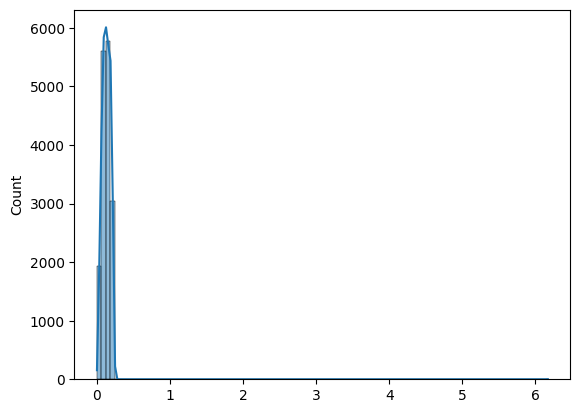

In [12]:
import seaborn as sns

dist = np.linalg.norm(data["goals"][term_ids] - data["observations"][term_ids, :2], axis=-1)
sns.histplot(dist, bins=100, kde=True)

In [14]:
[np.quantile(dist, q) for q in np.linspace(0.8, 0.99, 10)] + [np.max(dist)]

[0.1839537799358368,
 0.18792536477247873,
 0.191794749101003,
 0.19555109918117525,
 0.19970428109169006,
 0.2038428415854772,
 0.20844428956508637,
 0.21333398709694548,
 0.21925360321998597,
 0.22977624237537378,
 6.1707397]

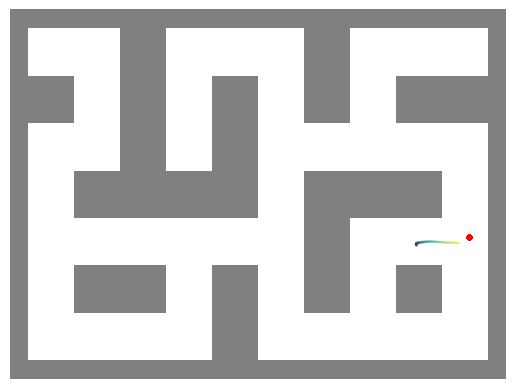

In [26]:
i = dist[:-1].argmax()
s, t = term_ids[i-1:i+1] + 1

render_env = GoalReachingMaze(env_name)
render_env.draw()

pos = data["observations"][s:t, :2]
goal = data["goals"][s:t]
c = np.linspace(0, 1, t - s)
plt.scatter(pos[:, 0], pos[:, 1], c=c, cmap='viridis', alpha=0.5, s=1)
plt.scatter(goal[:, 0], goal[:, 1], c='r', s=10)
plt.show()

<Axes: ylabel='Count'>

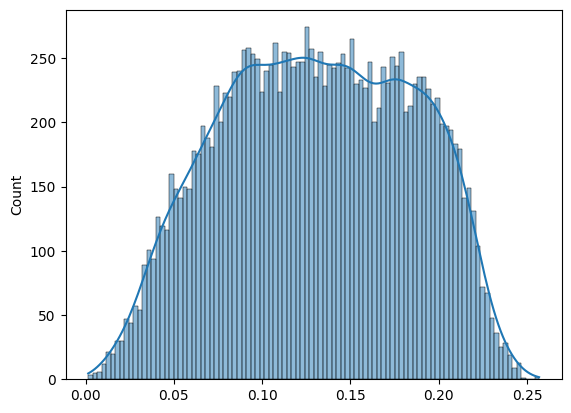

In [24]:
sns.histplot(dist[:-1], bins=100, kde=True)

In [25]:
dist[:-1].argmax()

6746